<a href="https://colab.research.google.com/github/af001/Predictive-Analytics/blob/master/MSDS422/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[*] Shape Raw: (4521, 17)
[*] Shape Clean: (4521, 17) 

[*] Column View: 
 ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'response']

[*] First 5 Records: 
    age          job  marital  education  ... pdays  previous poutcome response
0   30   unemployed  married    primary  ...    -1         0  unknown       no
1   33     services  married  secondary  ...   339         4  failure       no
2   35   management   single   tertiary  ...   330         1  failure       no
3   30   management  married   tertiary  ...    -1         0  unknown       no
4   59  blue-collar  married  secondary  ...    -1         0  unknown       no

[5 rows x 17 columns]

[*] Housing Model shape: (4521, 5)

Fold index: 0 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (3616, 4)
X_test: (905, 4)
y_train: (3616,)
y_test:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


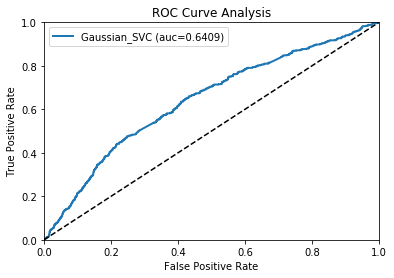

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


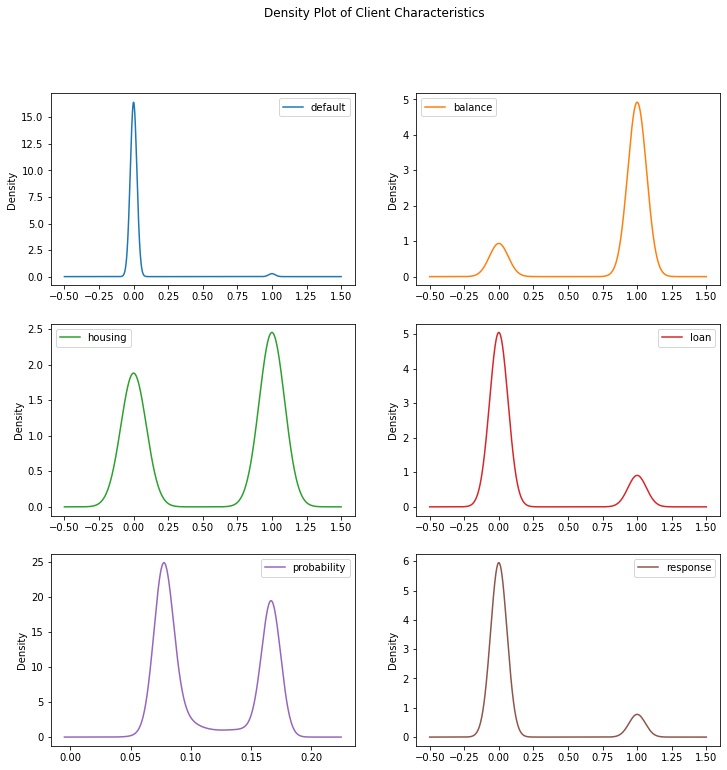

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author     :   Anton
@date:      :   10/15/2017
"""

import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# function used to plot ROC curve; when done, store the graphic to disk   
def plot_roc_curve(fpr, tpr, label, auc):
    plt.figure(1)
    plt.title('ROC Curve Analysis')
    plt.plot(fpr, tpr, linewidth=2, label='%s (auc=%s)' % (label, round(auc, 4)))
    plt.plot([0,1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig('roc-bank-best.pdf', bbox_inches='tight', dpi=None, 
                facecolor='w', edgecolor='b', orientation='portrait', 
                papertype=None, pad_inches=0.25, frameon=None)
    plt.show()

# function used to plot density of dataframe variables; when done, store the 
# graphic to disk   
def plot_density(df):
    df.plot(kind='density', subplots=True, layout=(3,2), sharex=False, 
            title='Density Plot of Client Characteristics', legend=True, 
            figsize=(12,12))
    plt.savefig('density-bank-best.pdf', bbox_inches='tight', dpi=None, 
                facecolor='w', edgecolor='b', orientation='portrait', 
                papertype=None, pad_inches=0.25, frameon=None)

def change_values(x):
    # used for testing if mean()/median() have better results. Change 0 
    # value to mu, and uncomment the below.
    # mu = bank['balance'].median(). 
    
    # If balance is greater than 0, then yes, else no.
    if x > 0:
        y='yes'
    else:
        y='no'
    return y

# set a random seed to maintain samples
RANDOM_SEED = 42

# five-fold cross-validation. Reducted to minimize time it takes the 
# script to complete
N_FOLDS = 5

# identify classifiers and store in lists
NAMES = ['Logistic_Regression', 'Linear_SVC', 'Poly_SVC', 'Gaussian_SVC']

# used for testing. transform explanatory variables to 1 or 0 only. Does
# not apply StandardScaler. Balance is generalized using 0 for a balance 
# < 0 or 1 for a balance > 0.
'''
CLASSIFIERS = [ 
        BernoulliNB(alpha=1.0, binarize=0.5, 
                    class_prior = [0.5, 0.5], fit_prior=False), 
        LogisticRegression(class_weight='balanced', solver='lbfgs', C=0.1),
        SVC(C=5, kernel='linear', probability=True, 
            class_weight='balanced'),
        SVC(C=5, kernel='poly', degree=3, coef0=1, 
            class_weight='balanced',  probability=True),
        SVC(C=5, kernel='rbf', gamma='auto', 
            probability=True, class_weight='balanced')]
'''

 # pipeline testing with StandardScalar on all variables. All variables
 # transformed into 1 or 0 except for balanace. StandardScaler will 
 # generalize appropriately. 
 # TODO: Research method to only do StandardScaler once for each iteration. 
 # That would speed up this process. 
CLASSIFIERS = [Pipeline((
                       ('scaler', StandardScaler()), 
                       ('logistic', LogisticRegression(class_weight='balanced', 
                                                       solver='lbfgs', C=0.1))
                       )),
               Pipeline((
                      ('scaler', StandardScaler()),
                       ('svm_clf', SVC(C=5, kernel='linear', probability=True, 
                                       class_weight='balanced', 
                                       random_state=RANDOM_SEED))
                       )),
               Pipeline((
                       ('scaler', StandardScaler()),
                       ('svm_clf', SVC(C=5, kernel='poly', degree=3, coef0=1, 
                                       class_weight='balanced',  
                                       probability=True,
                                       random_state=RANDOM_SEED))
                      )),
               Pipeline((
                       ('scaler', StandardScaler()),
                       ('svm_clf', SVC(C=5, kernel='rbf', gamma='auto', 
                                       probability=True, 
                                       class_weight='balanced',
                                       random_state=RANDOM_SEED))
                       ))]

# read the data from csv into a dataframe, drop np.nan values since 
# the shape remains the same. Print before / after of shape
bank = pd.read_csv('bank.csv', sep = ';')  
print('\n[*] Shape Raw: %s' % str(bank.shape))

bank.dropna(inplace=True)
print('[*] Shape Clean: %s ' % str(bank.shape))

# look at the list of column names, note that y is the response
print('\n[*] Column View: \n', list(bank.columns.values))

# look at first five records in DataFrame
print('\n[*] First 5 Records: \n', bank.head())

# handle text and categorical attributes. Using LabelEncoder instead of 
# mapping function to try something new.
encoder = LabelEncoder()

# define binary variable for having credit in default
default = encoder.fit_transform(bank['default'])

# define binary variable for having a mortgage or housing loan
housing = encoder.fit_transform(bank['housing'])

# define binary variable for having a personal loan
loan = encoder.fit_transform(bank['loan'])

# define response variable to use in the model
response = encoder.fit_transform(bank['response'])

# used for testing. Change balance to binary response. 1 for has a balance,
# or 0 for does not have a balance.
# bank['recur_balance'] = bank['balance'].apply(change_values)
# balance = encoder.fit_transform(bank['recur_balance'])
balance = bank['balance']

# used for testing. Apply standard scaler only to balance and then run.
#scaler = StandardScaler()
#balance = bank['balance'].values.reshape(1, -1)
#balance = scaler.fit_transform(balance)
#balance = np.squeeze(balance)

# gather three explanatory variables and response into a numpy array 
# here we use .T to obtain the transpose for the structure we want
model_data = np.array([np.array(default), 
                       np.array(housing), 
                       np.array(loan),
                       np.array(balance), 
                       np.array(response)]).T

# examine the shape of model_data, which we will use in subsequent modeling
print('\n[*] Housing Model shape: %s' % str(model_data.shape))

# set up numpy array for storing results
cv_results = np.zeros((N_FOLDS, len(NAMES)))
cv_results_ = np.zeros((N_FOLDS, len(NAMES)))

# split the data into folds using the random_seed
kf = KFold(n_splits = N_FOLDS, shuffle=False, random_state = RANDOM_SEED)

# set fold index and perform operations on each fold. Store index in numpy array.
index_for_fold = 0
for train_index, test_index in kf.split(model_data):
    print('\nFold index:', index_for_fold,
          '------------------------------------------')
    #   note that 0:model_data.shape[1]-1 slices for explanatory variables
    #   and model_data.shape[1]-1 is the index for the response variable    
    Xtrain = model_data[train_index, 0:model_data.shape[1]-1]
    Xtest = model_data[test_index, 0:model_data.shape[1]-1]
    ytrain = model_data[train_index, model_data.shape[1]-1]
    ytest = model_data[test_index, model_data.shape[1]-1]   
    print('\nShape of input data for this fold:',
          '\nData Set: (Observations, Variables)')
    print('X_train:', Xtrain.shape)
    print('X_test:',Xtest.shape)
    print('y_train:', ytrain.shape)
    print('y_test:',ytest.shape)
    
    # set method index and perform opreations on each classifier. Store results in
    # numpy array
    index_for_method = 0
    for name, clf in zip(NAMES, CLASSIFIERS):
        print('\n[*]Classifier evaluation for:', name)
        print('  Scikit Learn method:', clf)
        
        # fit the train set for the fold and evaulate using proba.
        # calculate roc auc and store in np array. Also calculate method
        # roc auc for being able to predict. Store in a np array for 
        # comparison
        clf.fit(Xtrain, ytrain)  
        yhat = clf.predict(Xtest)
        yhat_prob = clf.predict_proba(Xtest)
        
        # calculate auc for predict
        fold_method_result = roc_auc_score(ytest, yhat) 
        cv_results[index_for_fold, index_for_method] = fold_method_result
        
        # calculate auc for proba
        fold_method_result_ = roc_auc_score(ytest, yhat_prob[:, 1])
        cv_results_[index_for_fold, index_for_method] = fold_method_result_
        
        # print the predict results of each method
        print('  Area under ROC curve:', fold_method_result)
        print('  Classification Report:')
        print(metrics.classification_report(ytest, yhat))
        print('  Confusion Matrix:')
        print(metrics.confusion_matrix(ytest, yhat))

        index_for_method += 1
  
    index_for_fold += 1

# convert the results to a dataframe, add column names
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = NAMES
cv_results_df_ = pd.DataFrame(cv_results_)
cv_results_df_.columns = NAMES

print('\nAverage predict results from ', N_FOLDS, '-fold cross-validation:',
      '\nMethod\t\t\tArea under ROC Curve:', sep='')    
 
results = cv_results_df.mean().sort_values(ascending=False)
print(results)

# print the mean from the results of the folds (proba)
print('\nAverage proba results from ', N_FOLDS, '-fold cross-validation:',
      '\nMethod\t\t\tArea under ROC Curve:', sep='')    
 
results_ = cv_results_df_.mean().sort_values(ascending=False)
print(results_)

# show the best proba method and display the value of the auc
best = results_.index.values[0]
print('\nBest Method: ', best)
print('Best Method ROC: ', results_[0])

# test the algorithm on the entire dataset. Split the data into x and y
X = model_data[:, 0:model_data.shape[1]-1]
y = model_data[:, model_data.shape[1]-1]

# find the best algorithm in the list. Once found, fit the entire dataset
# ana perform analysis. 
for i in (i for i,x in enumerate(NAMES) if x == best):
    # assign best model to variable, fit, and perform predict and proba
    # on the dataset
    model = CLASSIFIERS[i]
    model.fit(X, y)
    q = model.predict_proba(X)
    r = model.predict(X)
    
    # print statistics after running the data against the entire dataset
    print('\nFinal Results using: %s' % best)
    print('Probability:', roc_auc_score(y, q[:,1]))
    
    # assign individual probabilities to the bank dataframe
    bank['probability'] = q[:,1]
    
    # create a new dataframe of the explanatory variables, reponse variable,
    # and probabilities
    analyze_df = bank.loc[:, 'default':'loan']
    analyze_df['probability'] = bank.loc[:, 'probability']
    analyze_df['response'] = bank.loc[:, 'response']
    analyze_df['balance'] = analyze_df['balance'].apply(change_values)

    # group the data to determine which combinations of explanatory variables
    # have the hightest probabilty of generating a 'yes' response. 
    print(analyze_df.groupby(['default', 'housing', 'loan', 'balance', 
                              'response']).mean())    

    # generate a set of test data, containing 16 rows, that cover each 
    # possibility. Based on the list of test data, attempt to predict the 
    # response. 
    test_data = list(itertools.product([0, 1], repeat=4))
    
    # print the results of predicting the response of the test data
    print('\nTest data using: %s' % best)
    print('default\thousing\tloan\tbalance\tprediction')
    
    # iterate over the list of test data and predict. Print the results to stdout
    true_hits = []
    for item in test_data:
        predict = model.predict([item])[0]
        print('%s\t%s\t%s\t%s\t%s' % (item[0], item[1], item[2], item[3], 
                                      predict))
        if predict == 1:
            true_hits.append(item)
    
    # show the best attributes of clients to target that will yield in the
    # highest probabilty of a yes response. 
    print('\nRecommended client attributes:')
    print('default\thousing\tloan\tbalance')
    for item in true_hits:
        print('%s\t%s\t%s\t%s' % (item[0], item[1], item[2], item[3]))
    
    # display the ROC curve of the best model against the entire dataset
    tpr, fpr, thresholds = metrics.roc_curve(y, q[:, 1])
    plot_roc_curve(tpr, fpr, best, roc_auc_score(y, q[:,1]))
    
    # to plot density, transform the data into integers based on the values
    # of yes / no ( 1 or 0). Use map instead of encoder to change it up. 
    convert_to_binary = {'no' : 0, 'yes' : 1}
    analyze_df['default'] = analyze_df['default'].map(convert_to_binary)
    analyze_df['housing'] = analyze_df['housing'].map(convert_to_binary)
    analyze_df['loan'] = analyze_df['loan'].map(convert_to_binary)
    analyze_df['balance'] = analyze_df['balance'].map(convert_to_binary)
    analyze_df['response'] = analyze_df['response'].map(convert_to_binary)
    
    # display a density graph to who the relationship of yes / no values
    # for each explanatory variable, response varable, and probability. 
    plot_density(analyze_df)